<a href="https://colab.research.google.com/github/jhashekhar/dnn-exp/blob/master/mnist_logs/log_sgd_epoch_600_bsize_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms

In [0]:

trainset = torchvision.datasets.MNIST(root='data/', 
                                      train=True, 
                                      transform = torchvision.transforms.Compose([
                                          transforms.ToTensor()]),
                                      download=True)

testset = torchvision.datasets.MNIST(root='data/', 
                                     train=False,
                                     transform = torchvision.transforms.Compose([
                                         transforms.ToTensor()]), 
                                     download=True)

In [0]:
split = 0.1
dataset_size = len(trainset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_split = int(np.floor(split * dataset_size))
train_indices = indices[val_split:]
val_indices = indices[:val_split] 

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

torch.Size([1, 28, 28])
torch.Size([28, 28])
Label: 4


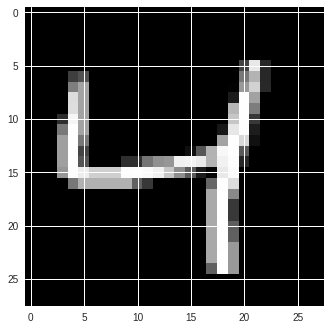

In [0]:
import matplotlib.pyplot as plt
img = trainset[2][0]
print(img.shape)
img = img.reshape(28, 28)
print(img.shape)
print('Label: {}'.format(trainset[2][1].item()))
plt.gray()
plt.imshow(img)

In [0]:
dataloaders = {'train': torch.utils.data.DataLoader(trainset, batch_size=16, sampler=train_sampler),
               'val': torch.utils.data.DataLoader(trainset, batch_size=16, sampler=valid_sampler),
               'test': torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)
              }

In [0]:
data_lengths = {'train': len(train_indices), 'val': len(val_indices), 'test': len(testset)}

In [0]:
data_lengths['train'], len(dataloaders['train'])

(54000, 3375)

In [0]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 25)
        self.fc2 = nn.Linear(25, 10)
        
    def forward(self, x):
        z1 = F.relu(self.fc1(x.view(16, -1)))
        out = self.fc2(z1)
        return out, z1
    
net = Net()
net = net.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
num_epochs = 600
fc2_grad_norm = []
fc1_grad_norm = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(num_epochs):
    print('Epoch: {}/{}'.format(epoch+1, num_epochs))
    print('='*10)
    
    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(dataloaders[phase]):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            _, preds = torch.max(outputs[0], 1)
            loss = criterion(outputs[0], labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss/data_lengths[phase]
        epoch_acc = running_corrects/data_lengths[phase]
        
        if phase == 'train':
            fc1_grad_norm.append(net.fc1.weight.grad.norm().item())
            fc2_grad_norm.append(net.fc2.weight.grad.norm().item())
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)            
        print('{} Loss: {:.4f},  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()
print('Finished Training')

Epoch: 1/600
train Loss: 0.6845,  Acc: 0.8247
val Loss: 0.3692,  Acc: 0.8950

Epoch: 2/600
train Loss: 0.3348,  Acc: 0.9048
val Loss: 0.3143,  Acc: 0.9110

Epoch: 3/600
train Loss: 0.2969,  Acc: 0.9149
val Loss: 0.2925,  Acc: 0.9170

Epoch: 4/600
train Loss: 0.2733,  Acc: 0.9225
val Loss: 0.2686,  Acc: 0.9243

Epoch: 5/600
train Loss: 0.2542,  Acc: 0.9276
val Loss: 0.2594,  Acc: 0.9268

Epoch: 6/600
train Loss: 0.2381,  Acc: 0.9313
val Loss: 0.2464,  Acc: 0.9293

Epoch: 7/600
train Loss: 0.2243,  Acc: 0.9361
val Loss: 0.2347,  Acc: 0.9333

Epoch: 8/600
train Loss: 0.2123,  Acc: 0.9400
val Loss: 0.2248,  Acc: 0.9380

Epoch: 9/600
train Loss: 0.2016,  Acc: 0.9426
val Loss: 0.2150,  Acc: 0.9395

Epoch: 10/600
train Loss: 0.1934,  Acc: 0.9450
val Loss: 0.2044,  Acc: 0.9433

Epoch: 11/600
train Loss: 0.1856,  Acc: 0.9477
val Loss: 0.1977,  Acc: 0.9465

Epoch: 12/600
train Loss: 0.1788,  Acc: 0.9496
val Loss: 0.1943,  Acc: 0.9467

Epoch: 13/600
train Loss: 0.1725,  Acc: 0.9517
val Loss: 0.19

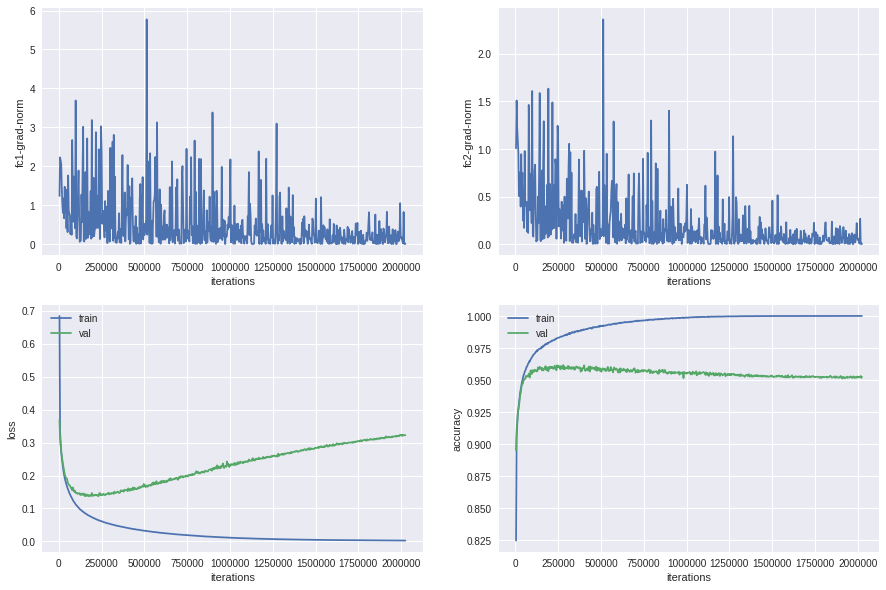

In [0]:
epoch_idx = []
for i in range(num_epochs):
  epoch_idx.append((i+1) * len(dataloaders['train']))

#epoch_idx = [i for i in range(num_epochs)]
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(epoch_idx, fc1_grad_norm)
plt.xlabel('iterations')
plt.ylabel('fc1-grad-norm')

plt.subplot(222)
plt.plot(epoch_idx, fc2_grad_norm)
plt.xlabel('iterations')
plt.ylabel('fc2-grad-norm')


plt.subplot(223)
plt.plot(epoch_idx, train_loss)
plt.plot(epoch_idx, val_loss)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(224)
plt.plot(epoch_idx, train_acc)
plt.plot(epoch_idx, val_acc)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
txt_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'fc1_grad_norm', 'fc2_grad_norm']
txt_dict = {'train_loss': train_loss, 
            'train_acc': train_acc, 
            'val_loss': val_loss, 
            'val_acc': val_acc,
            'fc1_grad_norm': fc1_grad_norm,
            'fc2_grad_norm': fc2_grad_norm}

with open('log_sgd_epoch_600_bsize_16.txt', 'w') as f:
    for item in txt_list:
        f.write(item)
        f.write("\n")
        for i in txt_dict[item]:
            f.write("%s, " % i)
        f.write("\n")